### Code Discussion 5<br>
#### Zixun Hao zh210

Please break the data up into a training (1600 entries, 80%) and test dataset (400 entries, 20%). Build a Naive Bayesian Classifier from scratch that tries to predict whether a respondent will vote in a presidential election or not, pr(Vote==1). The classifier must be built from scratch. Do not use a third party ML or statistical package.

Run your algorithm and see how it predicts on the test data. Use the sklearn.metrics library to calculate the predictive accuracy and the area underneath the ROC curve. Does your model perform better than chance (i.e. coin flip)?

### Import packages and data

In [9]:
# import packages 
import pandas as pd
import numpy as np

import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB 
import sklearn.metrics as m

In [55]:
# read in voter turnout data for the task 
df_turnout = pd.read_csv("../turnout.csv")
# drop the id column 
df_turnout = df_turnout.drop(["id"], axis=1)
# check out 5 random rows of the data
df_turnout.sample(5)

,age,educate,income,vote,white
1532,44,12.0,8.7220,1,1
126,41,15.0,4.4876,1,1
1402,34,17.0,9.5029,0,1
570,24,11.0,2.9170,0,1
1237,24,12.0,0.2364,0,1


### Break up the data into training and test dataset

In [56]:
# Set seed, so the split doesn't change as we rerun the code
np.random.seed(1234)

# Train-Test split (just using Pandas)
train = df_turnout.sample(frac=.8).reset_index(drop=True)
test = df_turnout.drop(train.index).reset_index(drop=True)

# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Look at the head of the data
train.head()

Training Data: 1600 
Test Data: 400


,age,educate,income,vote,white
0,78,16.0,1.3131,1,1
1,72,3.0,0.6765,1,0
2,64,10.0,1.3131,1,1
3,80,8.0,1.1839,1,1
4,19,14.0,2.9072,1,1


### Calculate Class Probabilities:  $Pr(vote)$

In [57]:
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

# Class probabilities.
pr_vote1 = vote1.shape[0]/train.shape[0]
pr_vote0 = vote0.shape[0]/train.shape[0]

# Print the class probabilities
print(
f"""
Pr(vote = 1): {pr_vote1}
Pr(vote = 0): {pr_vote0}
""")


Pr(vote = 1): 0.7425
Pr(vote = 0): 0.2575



### Calculate the Conditional Probability of Binary Variable: $Pr(white | vote)$

We have the following conditional probabilities for the binary variable race (Caucasian or not) :
- $Pr(white = 1 | vote = 1)$
- $Pr(white = 0 | vote = 1)$
- $Pr(white = 1 | vote = 0)$
- $Pr(white = 0 | vote = 0)$

In [58]:
white1_vote1= vote1.query("white == 1").shape[0]/vote1.shape[0] # probability of white given vote
white0_vote1= vote1.query("white == 0").shape[0]/vote1.shape[0] # probability of non-white given vote

white1_vote0= vote0.query("white == 1").shape[0]/vote0.shape[0] # probability of white given not vote
white0_vote0= vote0.query("white == 0").shape[0]/vote0.shape[0] # probability of non-white given not vote

# print the conditional probabilities 
print(
f"""
Pr(white = 1 | vote = 1): {white1_vote1}
Pr(white = 0 | vote = 1): {white0_vote1}
Pr(white = 1 | vote = 0): {white1_vote0}
Pr(white = 0 | vote = 0): {white0_vote0}
""")


Pr(white = 1 | vote = 1): 0.8686868686868687
Pr(white = 0 | vote = 1): 0.13131313131313133
Pr(white = 1 | vote = 0): 0.7985436893203883
Pr(white = 0 | vote = 0): 0.20145631067961164



In [59]:
# save results into a dictionary for later use
binary_probs={}
# iterate through the class outcomes
for y, d in train.groupby("vote"): 
    # calculate the conditional probabilities for white variable given the class.
    pr = d["white"].sum()/d.shape[0]
    binary_probs[("white",1,y)] = pr 
    binary_probs[("white",0,y)] = 1 - pr

print("The conditional probabilities of binary variable race are",end="\n\n")
pp.pprint(binary_probs)

The conditional probabilities of binary variable race are

{('white', 0, 0): 0.20145631067961167,
 ('white', 0, 1): 0.13131313131313127,
 ('white', 1, 0): 0.7985436893203883,
 ('white', 1, 1): 0.8686868686868687}


### Calculate the Probability Density Functions of Continuous Variables 

For continuous variables, age, years of education and income, we calculate the conditional means/standard deviations and use the PDF for Gaussian distribution to convert continuous values into probabilities.

In [26]:
# Collect the mean and standard deviation of each conditional distribution (age, education and income)
dist_locs = \
{("age", 1):{'mean':vote1.age.mean(),'sd':vote1.age.std()}, # probability of age given vote
 ("age", 0):{'mean':vote0.age.mean(),'sd':vote0.age.std()}, # probability of age given not vote
 ("educate",1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()}, # probability of education given vote
 ("educate",0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()}, # probability of education given not vote
 ("income",1):{'mean':vote1.income.mean(),'sd':vote1.income.std()}, # probability of income given vote
 ("income",0):{'mean':vote0.income.mean(),'sd':vote0.income.std()}, # probability of income given not vote
}

# Print the means and standard dev. 
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('age', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853727},
 ('educate', 0): {'mean': 10.62864077669903, 'sd': 3.3043810919835317},
 ('educate', 1): {'mean': 12.558922558922559, 'sd': 3.2957141274443202},
 ('income', 0): {'mean': 2.738161893203883, 'sd': 2.242991372933763},
 ('income', 1): {'mean': 4.229461952861953, 'sd': 2.848208991067699}}


We map these different conditional distributions on a plot: 

Text(-20, -20, 'Source: 2012 National Election Survey')

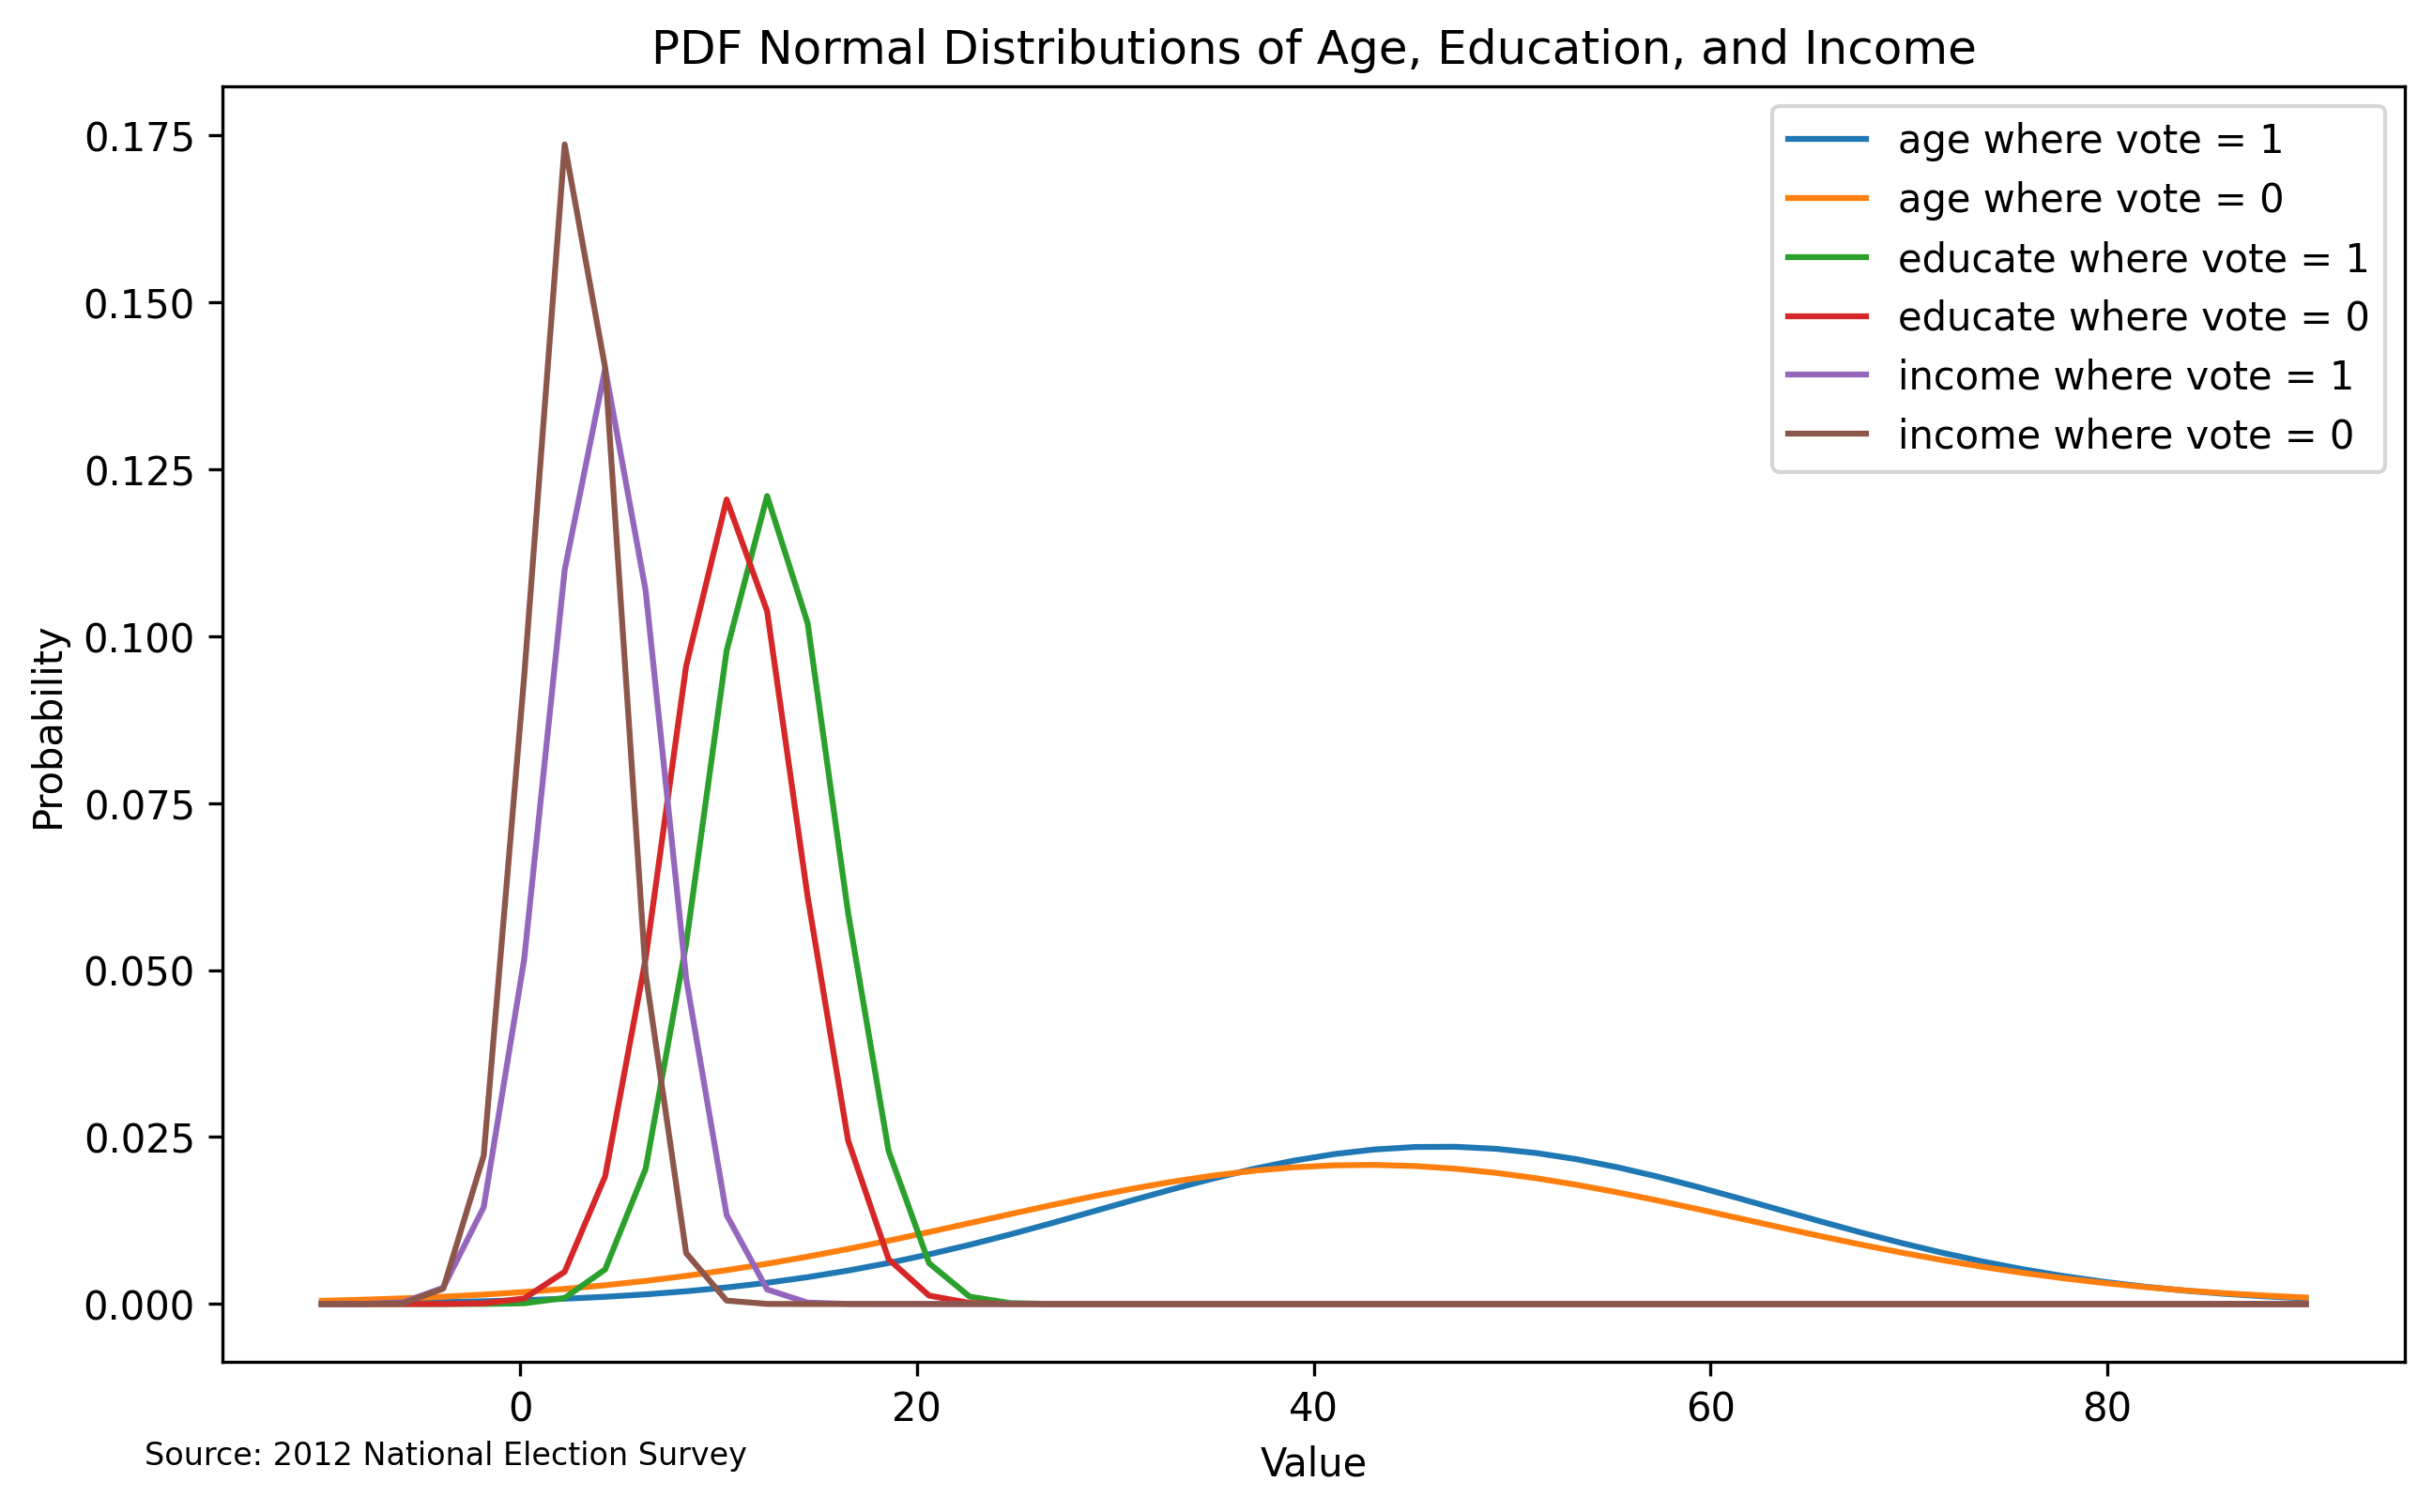

In [66]:
# Plot the different conditional distributions with seaborn
plt.figure(figsize=(10,6),dpi=300)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-10,90)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where vote = {key[1]}")
plt.xlabel('Value', fontsize=10)
plt.ylabel('Probability', fontsize=10)
plt.title("PDF Normal Distributions of Age, Education, and Income")
plt.annotate('Source: 2012 National Election Survey', (0,0), (-20,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')

### Predicting multiple observations from the training dataset

We combine the conditional probability of the binary variable with the probabilities of continuous varibles to predict multiple observations in our training dataset.<br>
We use the Naive Bayesian Classifier to predict whether someone will vote, the function can be written as:
$$Pr(vote | population) = Pr( race| vote)\times Pr( age| vote) \times Pr( educate| vote) \times Pr( income| vote) \times  Pr(vote)$$

In [62]:
def predict(data,dist_locs, binary_probs, binary_variable= ""):
    '''
    This function takes a training dataset as input, calculate the conditional 
    probability for both vote and not vote, then returns both the probabilities 
    and the most likely class (a prediction on vote or not vote)
    
    Inputs:
    data (dataframe): Training dataset 
    dist_locs (dictionary): A dictionary that includes the mean and standard deviation 
                            of each continous variable's distribution
    binaries_probs (dictionary): A dictionary that contains the binary variable probabilities
    binary_variable (str): A binary variable in the classifier
    '''
    # create empty list to hold conditional probabilities
    store_preds = []
    # locate all variables that are not the outcome variable
    vars = [v for v in data.columns if v != "vote"]
    
    # iterate through the training dataset
    for i,row in data.iterrows():
        # set the predictions of conditional probabilities to 1
        pr_0 = 1; pr_1 = 1
        
        for j in range(1,len(row)):
            # when vars is a binary variable
            if row.index[j] == binary_variable:
                pr_0*= binary_probs[(row.index[j],row.values[j],0)]
                pr_1*= binary_probs[(row.index[j],row.values[j],1)] 
            
            # when vars is a continuous variable
            elif row.index[j] in vars: 
                # get the predictions using a Gaussan distribution
                pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                                dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                                dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_vote0 # calculate the conditional probability into "not voting" class
        pr_1 *= pr_vote1 # calculate the conditional probability into "voting" class 
        
        # assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])


In [63]:
# run the function and display a random sample of predictions
preds_train = predict(train, dist_locs, binary_probs, binary_variable= "white")
preds_train.sample(10)

,pr_0,pr_1,pred
1261,0.003755,0.007635,1
436,0.004026,0.008940,1
414,0.002616,0.008924,1
1123,0.003396,0.006594,1
1262,0.002989,0.010736,1
1201,0.004343,0.007990,1
1018,0.003047,0.010753,1
1138,0.000202,0.004019,1
502,0.002231,0.001856,0
494,0.002624,0.008615,1


### Examine the predictive accuracy on training and test datasets

In [84]:
# run the function again on the test data
preds_test= predict(test, dist_locs, binary_probs, binary_variable= "white") 
preds_test.sample(10)

,pr_0,pr_1,pred
315,0.000003,0.000526,1
273,0.003555,0.004809,1
340,0.002590,0.002441,0
19,0.004283,0.006562,1
67,0.002318,0.002523,1
87,0.002571,0.007874,1
111,0.002615,0.010824,1
307,0.000348,0.001036,1
95,0.000032,0.001798,1
182,0.003207,0.003534,1


In [85]:
# examine the predictive accuracy on training data
accuracy_train= sum(train.vote == preds_train.pred)/train.shape[0]

# examine the predictive accuracy on testing data
accuracy_test= sum(test.vote == preds_test.pred)/test.shape[0]

print(
f"""
The predictive accuracy on the training dataset is {accuracy_train}.
The predictive accuracy on the test dataset is {accuracy_test}.
""")


The predictive accuracy on the training dataset is 0.73125.
The predictive accuracy on the test dataset is 0.7075.



### Use `sklearn` to calculate predictive accuracy and the ROC curve

In [95]:
# organize our data real quick so it plugs into the sklearn API easily 
train_y = train['vote'] # outcome variable
train_x = train[['age','educate','income','white']] # conditional variables (continuous and binary)
test_y = test['vote']
test_x = test[['age','educate','income','white']]

In [86]:
# instantiate the model class
gnb= GaussianNB()
gnb.fit(train_x, train_y) # train the prediction model

# predict 
y_pred= gnb.predict(test_x)

# out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.7125

The prediction model generated by `sklearn` has a 71.25% predictive accuracy on the test dataset, which is better than our Naive Bayesian model, but pretty close. <br>
Now use alternative performance metrics: compute area under the Receiver Operating Characteristic (ROC) curve from the prediction score.

In [88]:
# calculate the area under the curve for the sklearn model 
m.roc_auc_score(test_y,y_pred)

0.575595238095238

In [98]:
# calculate the area under the curve for our Naive Bayesian model
m.roc_auc_score(test_y,preds_test.pred)

0.5648809523809524

We see that the AUC of ROC of the sklearn model is larger than that of our Naive Bayesian model, indicating a better predictive accuracy.
<br>Generate a ROC curve plot. First, we need the model to return probabilities instead of predictions. 

In [89]:
# store conditional probabilities into a datadrame
probs = gnb.predict_proba(test_x)
probs =  pd.DataFrame(probs,columns=gnb.classes_)
probs

,0,1
0,0.382004,0.617996
1,0.089185,0.910815
2,0.275975,0.724025
3,0.255162,0.744838
4,0.036055,0.963945
...,...,...
395,0.168330,0.831670
396,0.274707,0.725293
397,0.021379,0.978621
398,0.438499,0.561501


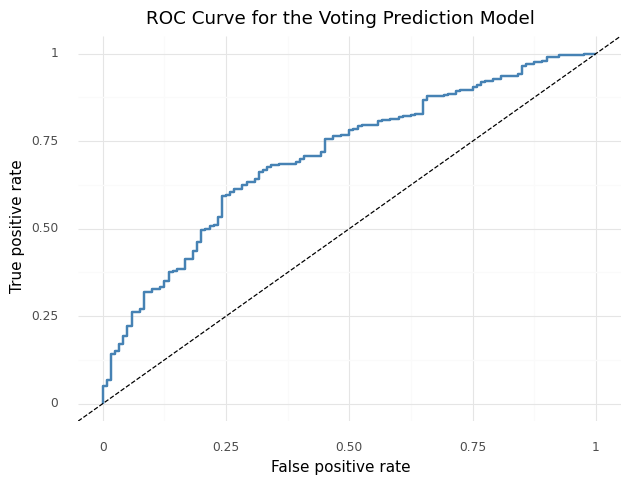

<ggplot: (303545061)>

In [100]:
# generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

# plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve for the Voting Prediction Model") +
    xlab("False positive rate")+
    ylab("True positive rate")+
    theme(figure_size=(7,5))
)

### Discussion

As shown above, our Naive Bayesian model has a predictive accuracy of 73.13% on the training data and a predictive accuracy of 70.75% on the test data. The sklearn API prediction model has a 71.25% accuracy on the test data, which is a better performance than our model on the test. The area under the ROC curve for the sklearn model is 0.576, larger than our model's AUC, which is 0.565. But neither model's accuracy, judging by the AUC, is satisfying. 

|      |  Vote (Pr=0.7425) |  Not Vote (Pr=0.2575) |
|----------|:-------------:|------:|
| Head (Pr=0.5) |  True Positive |  False Positive |
| Tail (Pr=0.5) | False Negative |   True Negative |

As the result of a coin flip is random and independent from the probability of voting or not, the probability of coin flip correctly "predicts" the outcome variable is:
$$Pr(correct) = Pr(Head)\times Pr(Vote) + Pr(Tail)\times Pr(Not Vote) = 0.5 \times 0.7425 + 0.5 \times 0.2575 = 0.5$$

So both our Naive Bayesian model and the sklearn prediction model perform better than chance.
